# MomentsLD Parameter Analysis: Best Fit vs Ground Truth

This notebook analyzes the MomentsLD optimization results from split migration experiments, comparing best fit parameters against ground truth values and visualizing parameter distributions across replicates. MomentsLD uses linkage disequilibrium (LD) statistics for demographic inference.

## Import Required Libraries

Import necessary libraries for data manipulation and visualization.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from pathlib import Path
import glob
from scipy import stats
import json

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

# Configure matplotlib
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## Set Up Data Paths

Define paths to the experiment directories containing simulations and MomentsLD results.

In [3]:
# Define base paths
base_path = Path('/sietch_colab/akapoor/Infer_Demography/experiments/drosophila_three_epoch/')
simulations_path = base_path / 'simulations'
inferences_path = base_path / 'inferences'

print(f"Base path: {base_path}")
print(f"Simulations path: {simulations_path}")
print(f"Inferences path: {inferences_path}")

# Check if paths exist
print(f"\nPaths exist:")
print(f"Simulations: {simulations_path.exists()}")
print(f"Inferences: {inferences_path.exists()}")

# Check MomentsLD results structure
momentsld_dirs = list(inferences_path.glob('sim_*/MomentsLD'))
print(f"\nFound {len(momentsld_dirs)} MomentsLD result directories")
if momentsld_dirs:
    print(f"Example: {momentsld_dirs[0]}")
    # List files in first MomentsLD directory
    example_files = list(momentsld_dirs[0].glob('*'))
    print(f"Files in MomentsLD directory:")
    for f in example_files[:10]:  # Show first 10 files
        print(f"  {f.name}")

Base path: /sietch_colab/akapoor/Infer_Demography/experiments/drosophila_three_epoch
Simulations path: /sietch_colab/akapoor/Infer_Demography/experiments/drosophila_three_epoch/simulations
Inferences path: /sietch_colab/akapoor/Infer_Demography/experiments/drosophila_three_epoch/inferences

Paths exist:
Simulations: True
Inferences: True

Found 5 MomentsLD result directories
Example: /sietch_colab/akapoor/Infer_Demography/experiments/drosophila_three_epoch/inferences/sim_2/MomentsLD
Files in MomentsLD directory:
  windows
  LD_stats
  means.varcovs.pkl
  bootstrap_sets.pkl
  empirical_vs_theoretical_comparison.pdf
  best_fit.pkl


## Load Ground Truth Parameters

Load the true parameter values used for each simulation replicate.

In [4]:
def load_ground_truth_params(sim_dir):
    """Load ground truth parameters from a simulation directory."""
    sampled_params_file = sim_dir / 'sampled_params.pkl'
    if sampled_params_file.exists():
        with open(sampled_params_file, 'rb') as f:
            return pickle.load(f)
    return None

# Load ground truth parameters for all simulations
ground_truth_data = []
# Look for numbered directories (0, 1, 2, ...) not sim_* pattern
sim_dirs = sorted([d for d in simulations_path.iterdir() if d.is_dir() and d.name.isdigit()])

print(f"Loading ground truth parameters from {len(sim_dirs)} simulations...")

for sim_dir in sim_dirs:
    sim_id = int(sim_dir.name)  # Directory name is just the number
    params = load_ground_truth_params(sim_dir)
    
    if params is not None:
        params['sim_id'] = sim_id
        ground_truth_data.append(params)
        if sim_id == 0:  # Debug: show what's in the first simulation
            print(f"DEBUG: Simulation 0 ground truth parameters: {params}")

# Convert to DataFrame
gt_df = pd.DataFrame(ground_truth_data)
print(f"\nLoaded ground truth for {len(gt_df)} simulations")
if not gt_df.empty:
    print("\nGround truth parameter summary:")
    print(gt_df.describe())
else:
    print("ERROR: No ground truth data loaded!")

Loading ground truth parameters from 50 simulations...
DEBUG: Simulation 0 ground truth parameters: {'N0': 16609.340728339448, 'AFR': 15971.960993801307, 'EUR_bottleneck': 4321.270015574636, 'EUR_recover': 14249.992552127915, 'T_AFR_expansion': 64126.60218314743, 'T_AFR_EUR_split': 48049.271713833485, 'T_EUR_expansion': 6969.687466918001, 'sim_id': 0}

Loaded ground truth for 50 simulations

Ground truth parameter summary:
                 N0           AFR  EUR_bottleneck   EUR_recover  \
count     50.000000     50.000000       50.000000     50.000000   
mean   13216.377438  18181.655498     2498.121315  11406.802994   
std     3982.043283   7642.046492     1328.547629   5421.252870   
min     5166.904918   5166.878067      296.142017   1121.401289   
25%    10478.357588  11735.667264     1367.795064   6894.758995   
50%    13616.808491  18495.788762     2666.685394  12706.989840   
75%    16488.763026  24285.910589     3497.513888  14749.816180   
max    19964.581286  29806.471721    

## Load Coverage Data

Load coverage percentage data from bgs.meta.json files to colorize plots by selection strength.

In [5]:
def load_coverage_data(simulations_path):
    """Load coverage percentage data from bgs.meta.json files."""
    coverage_data = {}
    
    # Look for numbered directories (0, 1, 2, ...) to match ground truth loading
    sim_dirs = sorted([d for d in simulations_path.iterdir() if d.is_dir() and d.name.isdigit()])
    
    for sim_dir in sim_dirs:
        sim_id = int(sim_dir.name)
        meta_file = sim_dir / 'bgs.meta.json'
        
        if meta_file.exists():
            try:
                with open(meta_file, 'r') as f:
                    meta = json.load(f)
                coverage_data[sim_id] = meta.get('sampled_coverage_percent', None)
            except Exception as e:
                print(f"Error loading {meta_file}: {e}")
                coverage_data[sim_id] = None
        else:
            coverage_data[sim_id] = None
    
    print(f"Loaded coverage data for {len(coverage_data)} simulations")
    valid_coverage = sum(1 for v in coverage_data.values() if v is not None)
    print(f"  {valid_coverage} simulations have coverage data")
    
    if valid_coverage > 0:
        coverage_values = [v for v in coverage_data.values() if v is not None]
        print(f"  Coverage range: {min(coverage_values):.1f}% - {max(coverage_values):.1f}%")
        print(f"  Mean coverage: {np.mean(coverage_values):.1f}%")
    
    return coverage_data

# Load coverage data
coverage_data = load_coverage_data(simulations_path)

# Add coverage data to ground truth DataFrame
if not gt_df.empty and coverage_data:
    gt_df['coverage_percent'] = gt_df['sim_id'].map(coverage_data)
    print(f"\nCoverage data added to ground truth DataFrame")
    print(f"Simulations with coverage data: {gt_df['coverage_percent'].notna().sum()}/{len(gt_df)}")
else:
    print("\nNo coverage data to add to ground truth DataFrame")

Loaded coverage data for 50 simulations
  0 simulations have coverage data

Coverage data added to ground truth DataFrame
Simulations with coverage data: 0/50


## Load MomentsLD Best Fit Results

Load the best fit parameters from MomentsLD optimization for each simulation.

In [6]:
def load_momentsld_results(momentsld_dir):
    """Load MomentsLD best fit results from a MomentsLD directory."""
    best_fit_file = momentsld_dir / 'best_fit.pkl'
    if best_fit_file.exists():
        with open(best_fit_file, 'rb') as f:
            return pickle.load(f)
    return None

# Load MomentsLD results for all simulations
momentsld_data = []

print(f"Loading MomentsLD results from {len(momentsld_dirs)} directories...")

for momentsld_dir in sorted(momentsld_dirs):
    # Extract sim_id from path
    sim_id = int(momentsld_dir.parent.name.split('_')[1])
    results = load_momentsld_results(momentsld_dir)
    
    if results is not None:
        # Extract best fit parameters
        best_params = results.get('best_params', {})
        # Note: key is 'best_lls' not 'best_ll'
        best_ll = results.get('best_lls', np.nan)
        
        # Add simulation metadata
        result_entry = best_params.copy()
        result_entry['sim_id'] = sim_id
        result_entry['log_likelihood'] = best_ll
        
        momentsld_data.append(result_entry)

# Convert to DataFrame
momentsld_df = pd.DataFrame(momentsld_data)
print(f"\nLoaded MomentsLD results for {len(momentsld_df)} simulations")

if not momentsld_df.empty:
    print("\nMomentsLD parameter summary:")
    # Show numeric columns only
    numeric_cols = momentsld_df.select_dtypes(include=[np.number]).columns
    print(momentsld_df[numeric_cols].describe())
else:
    print("No MomentsLD results found!")

Loading MomentsLD results from 5 directories...

Loaded MomentsLD results for 5 simulations

MomentsLD parameter summary:
                 N0           AFR  EUR_bottleneck   EUR_recover  \
count      5.000000      5.000000        5.000000      5.000000   
mean   14082.667264  11798.372158     2455.990240  16124.277560   
std     4468.034492   5372.548142     1668.162826   2542.866449   
min     6838.482645   6119.400791      360.967785  12876.395578   
25%    13596.959854   7016.770912     1506.327804  14546.020692   
50%    14784.488941  11495.349579     2149.090432  16681.880870   
75%    16609.340728  16102.358438     3877.476138  16953.951965   
max    18584.064150  18257.981069     4386.089040  19563.138697   

       T_AFR_expansion  T_AFR_EUR_split  T_EUR_expansion    sim_id  \
count         5.000000         5.000000         5.000000  5.000000   
mean     111129.786074     33046.089361      5782.384126  2.000000   
std       58005.031041     15828.127123      2222.533287  1.5811

## Merge Ground Truth and MomentsLD Results

Combine the ground truth and best fit parameters for comparison analysis.

In [7]:
# Merge ground truth and MomentsLD results
if not gt_df.empty and not momentsld_df.empty:
    # Merge on sim_id
    merged_df = pd.merge(gt_df, momentsld_df, on='sim_id', suffixes=('_true', '_momentsld'))
    
    print(f"Successfully merged data for {len(merged_df)} simulations")
    print(f"\nColumns in merged dataset:")
    for col in merged_df.columns:
        print(f"  {col}")
        
    # Display first few rows
    print(f"\nFirst 5 rows of merged data:")
    print(merged_df.head())
else:
    print("Cannot merge - missing ground truth or MomentsLD data")
    merged_df = pd.DataFrame()

Successfully merged data for 5 simulations

Columns in merged dataset:
  N0_true
  AFR_true
  EUR_bottleneck_true
  EUR_recover_true
  T_AFR_expansion_true
  T_AFR_EUR_split_true
  T_EUR_expansion_true
  sim_id
  coverage_percent
  N0_momentsld
  AFR_momentsld
  EUR_bottleneck_momentsld
  EUR_recover_momentsld
  T_AFR_expansion_momentsld
  T_AFR_EUR_split_momentsld
  T_EUR_expansion_momentsld
  log_likelihood

First 5 rows of merged data:
        N0_true      AFR_true  EUR_bottleneck_true  EUR_recover_true  \
0  16609.340728  15971.960994          4321.270016      14249.992552   
1  14784.488941   6094.383091           296.142017      16945.039068   
2   6838.482645  11452.826869          2147.699494      19414.495015   
3  13596.959854  18212.278629          3865.521151      16422.162573   
4  18584.064150   6930.669830          1508.334828      12815.159163   

   T_AFR_expansion_true  T_AFR_EUR_split_true  T_EUR_expansion_true  sim_id  \
0          64126.602183          48049.271714

## Parameter Comparison Analysis

Compare the inferred parameters with ground truth values.

In [8]:
if not merged_df.empty:
    # Define parameter pairs for comparison
    param_pairs = []
    
    # Find matching parameter names
    for col in merged_df.columns:
        if col.endswith('_true'):
            param_name = col.replace('_true', '')
            momentsld_col = param_name + '_momentsld'
            if momentsld_col in merged_df.columns:
                param_pairs.append((param_name, col, momentsld_col))
    
    print(f"Found {len(param_pairs)} parameter pairs for comparison:")
    for param_name, true_col, fit_col in param_pairs:
        print(f"  {param_name}: {true_col} vs {fit_col}")
    
    # Calculate relative errors
    comparison_data = []
    
    for param_name, true_col, fit_col in param_pairs:
        for idx, row in merged_df.iterrows():
            true_val = row[true_col]
            fit_val = row[fit_col]
            
            if pd.notna(true_val) and pd.notna(fit_val) and true_val != 0:
                rel_error = (fit_val - true_val) / true_val
                abs_rel_error = abs(rel_error)
                
                comparison_data.append({
                    'sim_id': row['sim_id'],
                    'parameter': param_name,
                    'true_value': true_val,
                    'fitted_value': fit_val,
                    'relative_error': rel_error,
                    'abs_relative_error': abs_rel_error,
                    'log_likelihood': row.get('log_likelihood', np.nan)
                })
    
    comparison_df = pd.DataFrame(comparison_data)
    print(f"\nCreated comparison dataset with {len(comparison_df)} parameter comparisons")
    
    if not comparison_df.empty:
        print("\nRelative error summary by parameter:")
        error_summary = comparison_df.groupby('parameter')['relative_error'].agg([
            'count', 'mean', 'std', 'median', 
            lambda x: np.percentile(x, 25), 
            lambda x: np.percentile(x, 75)
        ]).round(4)
        error_summary.columns = ['count', 'mean', 'std', 'median', 'q25', 'q75']
        print(error_summary)
else:
    print("No data available for parameter comparison")
    comparison_df = pd.DataFrame()

Found 7 parameter pairs for comparison:
  N0: N0_true vs N0_momentsld
  AFR: AFR_true vs AFR_momentsld
  EUR_bottleneck: EUR_bottleneck_true vs EUR_bottleneck_momentsld
  EUR_recover: EUR_recover_true vs EUR_recover_momentsld
  T_AFR_expansion: T_AFR_expansion_true vs T_AFR_expansion_momentsld
  T_AFR_EUR_split: T_AFR_EUR_split_true vs T_AFR_EUR_split_momentsld
  T_EUR_expansion: T_EUR_expansion_true vs T_EUR_expansion_momentsld

Created comparison dataset with 35 parameter comparisons

Relative error summary by parameter:
                 count    mean     std  median     q25     q75
parameter                                                     
AFR                  5  0.0062  0.0041  0.0041  0.0037  0.0082
EUR_bottleneck       5  0.0473  0.0962  0.0031  0.0006  0.0150
EUR_recover          5  0.0099  0.0083  0.0077  0.0048  0.0158
N0                   5 -0.0000  0.0000 -0.0000 -0.0000  0.0000
T_AFR_EUR_split      5  0.0071  0.0071  0.0065  0.0051  0.0114
T_AFR_expansion      5 -0.0824

In [9]:
# Add coverage data to the comparison dataset if available
if not comparison_df.empty and 'coverage_percent' in gt_df.columns:
    # Create sim_id to coverage mapping
    coverage_map = gt_df.set_index('sim_id')['coverage_percent'].to_dict()
    
    # Add coverage data to comparison_df
    comparison_df['coverage_percent'] = comparison_df['sim_id'].map(coverage_map)
    
    print(f"\nAdded coverage data to comparison dataset")
    print(f"Comparisons with coverage data: {comparison_df['coverage_percent'].notna().sum()}/{len(comparison_df)}")
    
    if comparison_df['coverage_percent'].notna().sum() > 0:
        print(f"Coverage range in comparison data: {comparison_df['coverage_percent'].min():.1f}% - {comparison_df['coverage_percent'].max():.1f}%")
else:
    print("\nNo coverage data available for comparison dataset")
    comparison_df['coverage_percent'] = np.nan

# Display the updated comparison dataframe
comparison_df


Added coverage data to comparison dataset
Comparisons with coverage data: 0/35


,sim_id,parameter,true_value,fitted_value,relative_error,abs_relative_error,log_likelihood,coverage_percent
0,0,N0,16609.340728,16609.340728,6.570963e-16,6.570963e-16,-133.227287,None
1,1,N0,14784.488941,14784.488941,-8.612354e-16,8.612354e-16,-675.501684,None
2,2,N0,6838.482645,6838.482645,-5.319863e-16,5.319863e-16,-105.551437,None
3,3,N0,13596.959854,13596.959854,-6.688956e-16,6.688956e-16,-98.297864,None
4,4,N0,18584.064150,18584.064150,1.957580e-16,1.957580e-16,-120.102124,None
5,0,AFR,15971.960994,16102.358438,8.164147e-03,8.164147e-03,-133.227287,None
6,1,AFR,6094.383091,6119.400791,4.105042e-03,4.105042e-03,-675.501684,None
7,2,AFR,11452.826869,11495.349579,3.712857e-03,3.712857e-03,-105.551437,None
8,3,AFR,18212.278629,18257.981069,2.509430e-03,2.509430e-03,-98.297864,None
9,4,AFR,6930.669830,7016.770912,1.242320e-02,1.242320e-02,-120.102124,None


## Visualize Parameter Accuracy

Create plots to visualize how well MomentsLD recovers the true parameters.

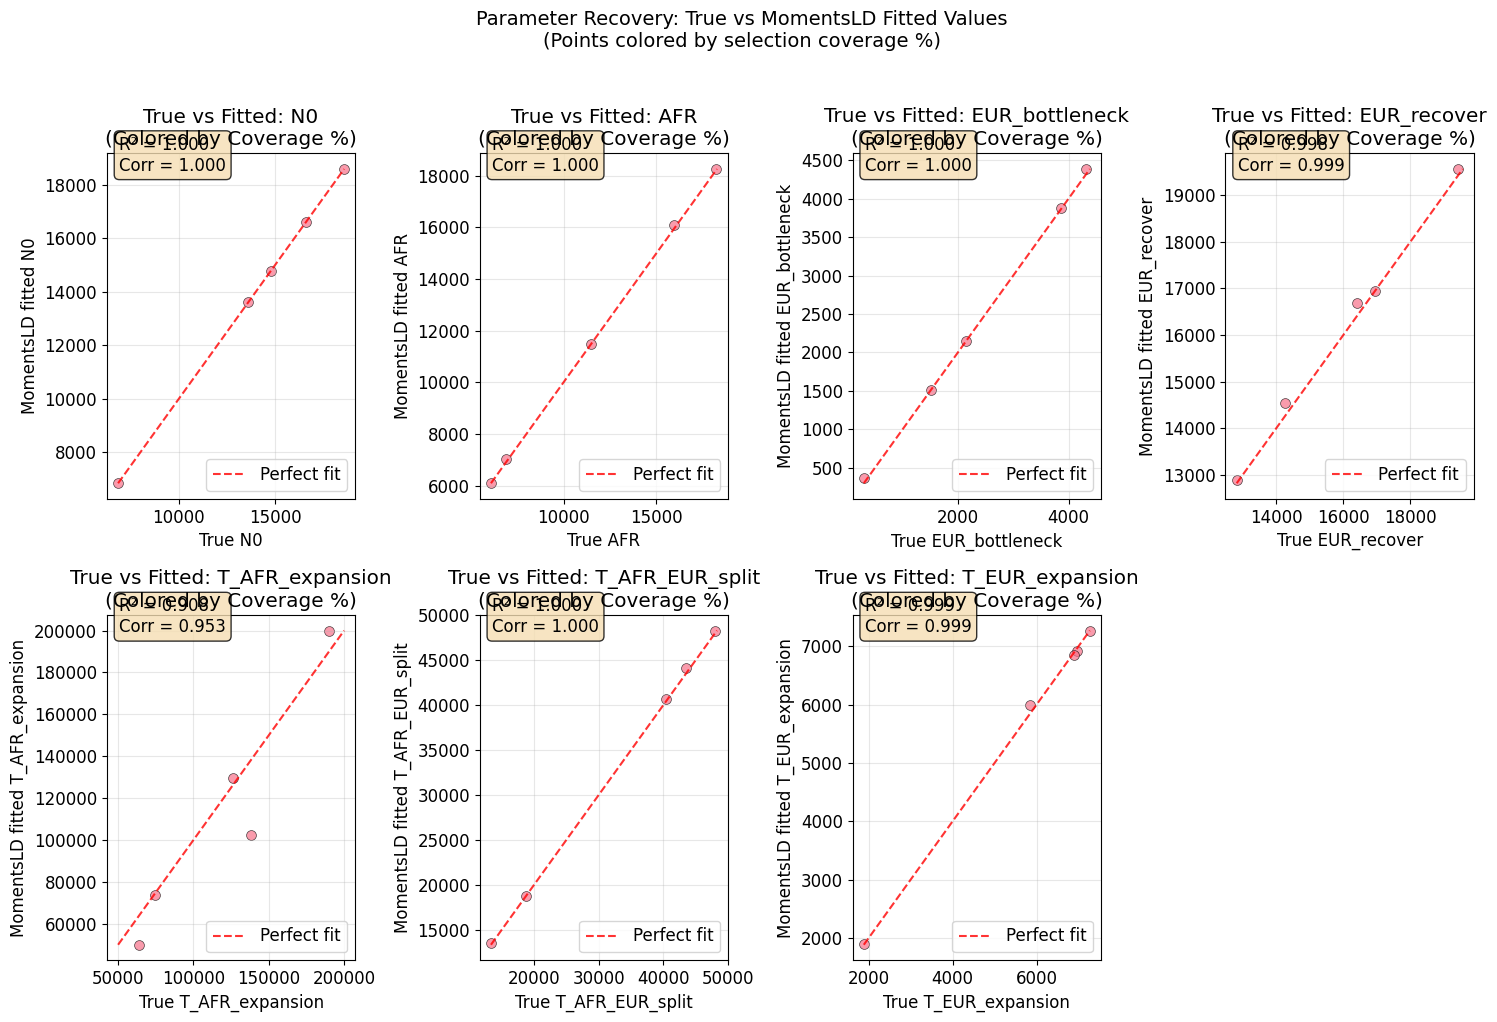

In [10]:
if not comparison_df.empty:
    # 1. True vs Fitted Values Scatter Plot (colored by coverage)
    unique_params = comparison_df['parameter'].unique()
    n_params = len(unique_params)
    
    fig, axes = plt.subplots(2, (n_params + 1) // 2, figsize=(15, 10))
    if n_params == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    for i, param in enumerate(unique_params):
        if i >= len(axes):
            break
            
        param_data = comparison_df[comparison_df['parameter'] == param]
        
        ax = axes[i]
        
        # Scatter plot colored by coverage percentage
        coverage = param_data['coverage_percent']
        valid_coverage = coverage.notna()
        
        if valid_coverage.sum() > 0:
            # Plot points with coverage data
            scatter = ax.scatter(param_data[valid_coverage]['true_value'], 
                               param_data[valid_coverage]['fitted_value'],
                               c=coverage[valid_coverage], 
                               cmap='viridis', alpha=0.7, s=50, 
                               edgecolors='black', linewidth=0.5)
            
            # Add colorbar for the first plot only
            if i == 0:
                cbar = plt.colorbar(scatter, ax=ax)
                cbar.set_label('Coverage Percent (%)')
            
            # Plot points without coverage data in gray (if any)
            if valid_coverage.sum() < len(param_data):
                ax.scatter(param_data[~valid_coverage]['true_value'], 
                          param_data[~valid_coverage]['fitted_value'],
                          c='gray', alpha=0.5, s=50, 
                          edgecolors='black', linewidth=0.5,
                          label='No coverage data')
        else:
            # If no coverage data available, plot all in single color
            ax.scatter(param_data['true_value'], param_data['fitted_value'], 
                      alpha=0.7, s=50, edgecolors='black', linewidth=0.5)
        
        # Add perfect fit line
        min_val = min(param_data['true_value'].min(), param_data['fitted_value'].min())
        max_val = max(param_data['true_value'].max(), param_data['fitted_value'].max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, label='Perfect fit')
        
        ax.set_xlabel(f'True {param}')
        ax.set_ylabel(f'MomentsLD fitted {param}')
        ax.set_title(f'True vs Fitted: {param}\n(Colored by Coverage %)')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Calculate and display R² and correlation
        r_squared = stats.pearsonr(param_data['true_value'], param_data['fitted_value'])[0]**2
        correlation = stats.pearsonr(param_data['true_value'], param_data['fitted_value'])[0]
        ax.text(0.05, 0.95, f'R² = {r_squared:.3f}\nCorr = {correlation:.3f}', 
                transform=ax.transAxes, 
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
    
    plt.suptitle('Parameter Recovery: True vs MomentsLD Fitted Values\n(Points colored by selection coverage %)', 
                 fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

## Individual Parameter Analysis with Coverage Coloring

Detailed analysis functions for individual parameters with coverage-based visualization.

Plotting individual parameters with coverage coloring...


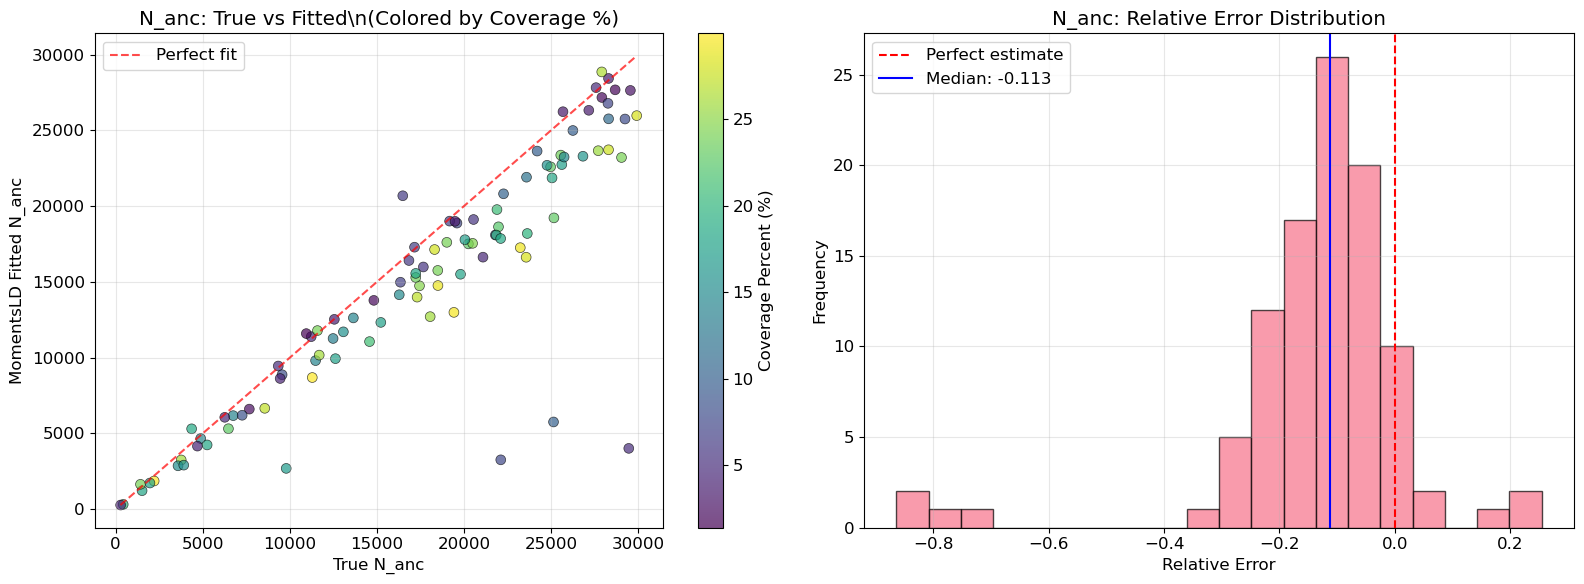

\nN_anc Statistics:
  Estimates: 100
  Correlation: 0.8894
  RMSE: 4565.5871
  Mean relative error: -0.1339
  Std relative error: 0.1693
  Coverage range: 1.4% - 30.0%
  Mean coverage: 15.2%
\n----------------------------------------\n


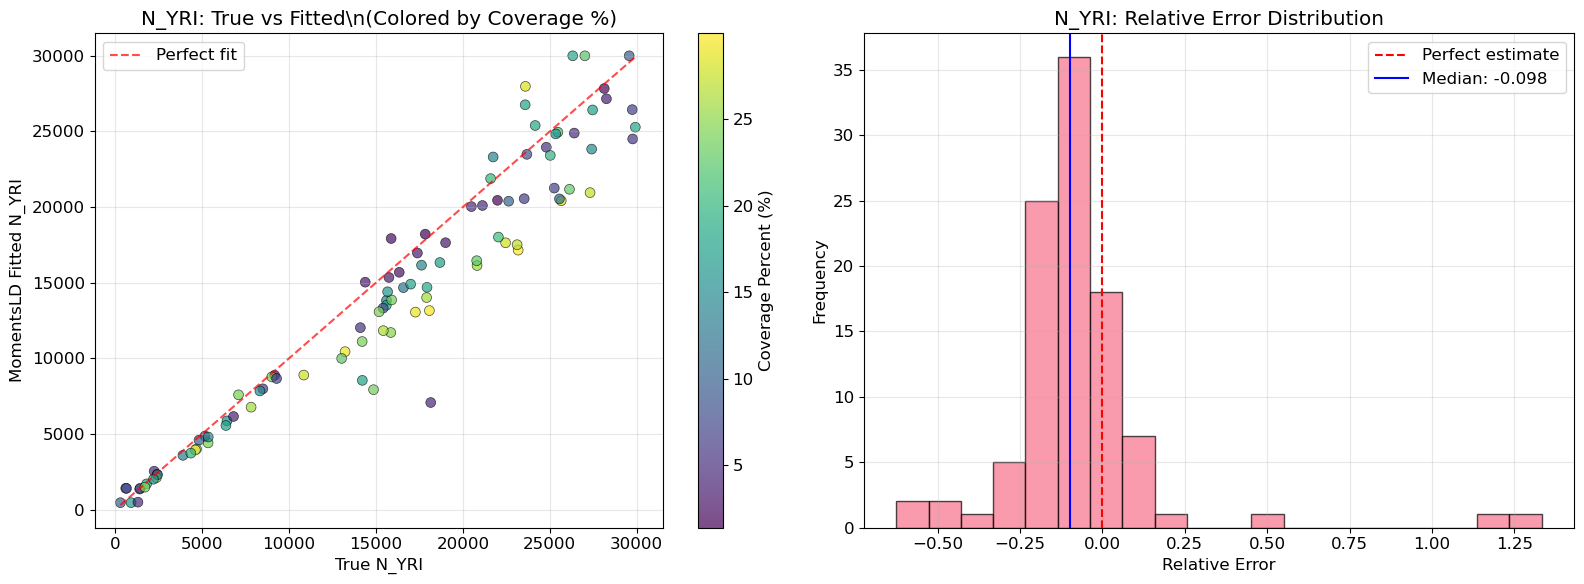

\nN_YRI Statistics:
  Estimates: 100
  Correlation: 0.9630
  RMSE: 2874.0903
  Mean relative error: -0.0787
  Std relative error: 0.2426
  Coverage range: 1.4% - 30.0%
  Mean coverage: 15.2%
\n----------------------------------------\n


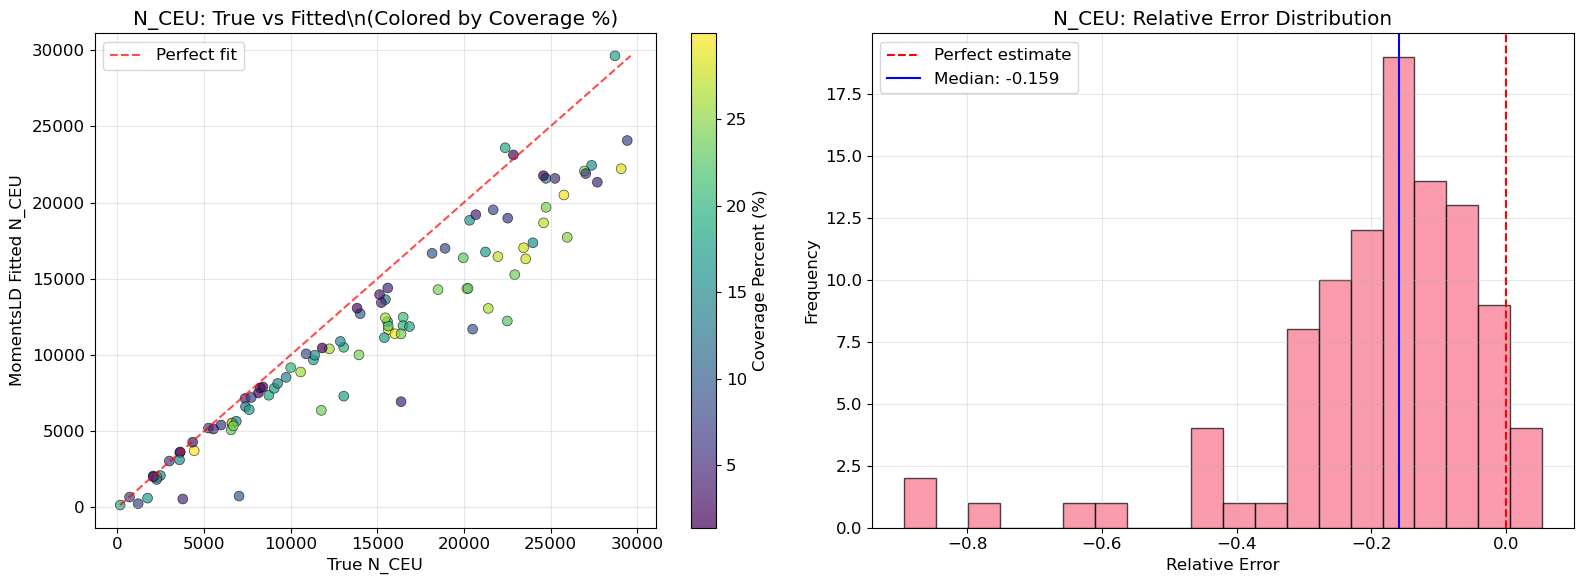

\nN_CEU Statistics:
  Estimates: 100
  Correlation: 0.9559
  RMSE: 3819.4729
  Mean relative error: -0.1929
  Std relative error: 0.1710
  Coverage range: 1.4% - 30.0%
  Mean coverage: 15.2%
\n----------------------------------------\n


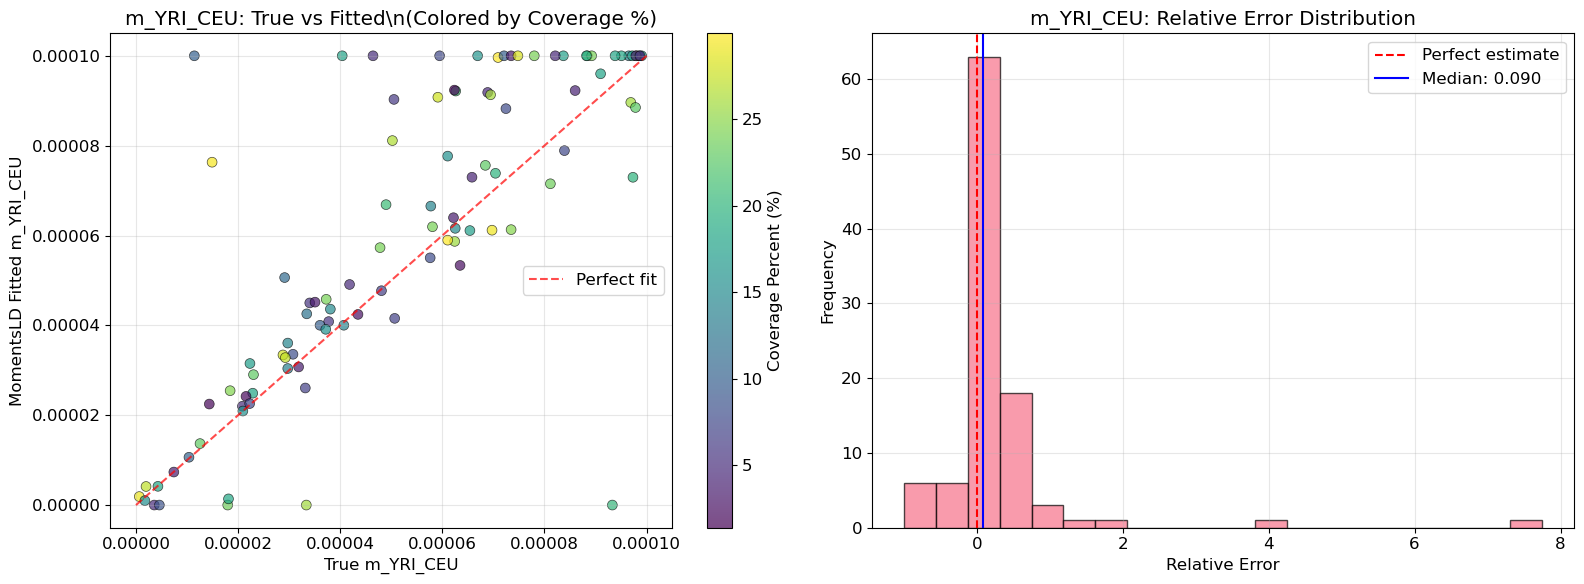

\nm_YRI_CEU Statistics:
  Estimates: 100
  Correlation: 0.8040
  RMSE: 0.0000
  Mean relative error: 0.2366
  Std relative error: 0.9620
  Coverage range: 1.4% - 30.0%
  Mean coverage: 15.2%
\n----------------------------------------\n


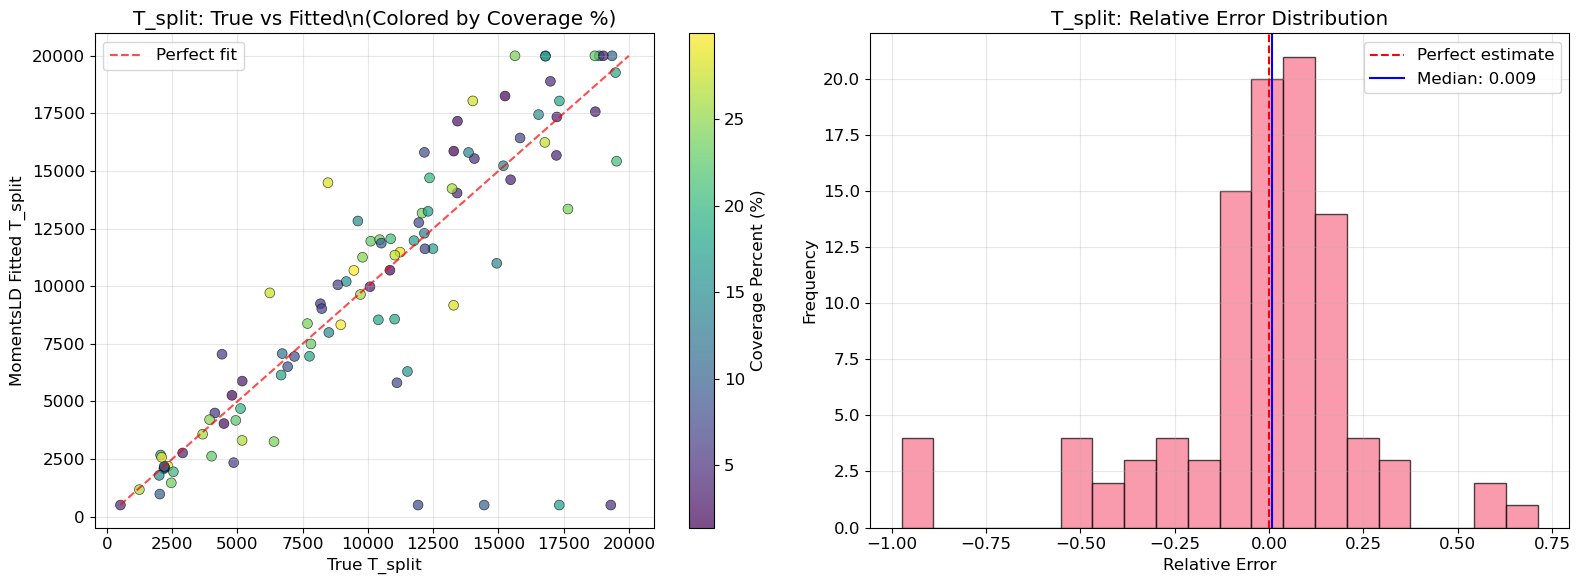

\nT_split Statistics:
  Estimates: 100
  Correlation: 0.7971
  RMSE: 3655.9246
  Mean relative error: -0.0285
  Std relative error: 0.2856
  Coverage range: 1.4% - 30.0%
  Mean coverage: 15.2%
\n----------------------------------------\n


In [10]:
def plot_parameter_with_coverage(df, param_name):
    """Plot ground truth vs estimated for a parameter, colored by coverage percentage."""
    param_data = df[df['parameter'] == param_name].copy()
    
    if len(param_data) == 0:
        print(f"No data for parameter {param_name}")
        return
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Scatter plot colored by coverage
    coverage = param_data['coverage_percent']
    
    # Handle case where some coverage data might be missing
    valid_coverage = coverage.notna()
    
    if valid_coverage.sum() > 0:
        # Plot points with coverage data
        scatter = ax1.scatter(param_data[valid_coverage]['true_value'], 
                            param_data[valid_coverage]['fitted_value'],
                            c=coverage[valid_coverage], 
                            cmap='viridis', alpha=0.7, s=50, 
                            edgecolors='black', linewidth=0.5)
        
        # Add colorbar
        cbar = plt.colorbar(scatter, ax=ax1)
        cbar.set_label('Coverage Percent (%)')
        
        # Plot points without coverage data in gray (if any)
        if valid_coverage.sum() < len(param_data):
            ax1.scatter(param_data[~valid_coverage]['true_value'], 
                       param_data[~valid_coverage]['fitted_value'],
                       c='gray', alpha=0.5, s=50, 
                       edgecolors='black', linewidth=0.5,
                       label='No coverage data')
    else:
        # If no coverage data available, plot all in single color
        ax1.scatter(param_data['true_value'], param_data['fitted_value'], 
                   alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
    
    # Identity line
    min_val = min(param_data['true_value'].min(), param_data['fitted_value'].min())
    max_val = max(param_data['true_value'].max(), param_data['fitted_value'].max())
    ax1.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.7, label='Perfect fit')
    
    ax1.set_xlabel(f'True {param_name}')
    ax1.set_ylabel(f'MomentsLD Fitted {param_name}')
    ax1.set_title(f'{param_name}: True vs Fitted\\n(Colored by Coverage %)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Error histogram
    param_data['relative_error'] = (param_data['fitted_value'] - param_data['true_value']) / param_data['true_value']
    valid_errors = param_data['relative_error'].dropna()
    
    if len(valid_errors) > 0:
        ax2.hist(valid_errors, bins=20, alpha=0.7, edgecolor='black')
        ax2.axvline(0, color='red', linestyle='--', label='Perfect estimate')
        ax2.axvline(valid_errors.median(), color='blue', linestyle='-', 
                   label=f'Median: {valid_errors.median():.3f}')
    
    ax2.set_xlabel('Relative Error')
    ax2.set_ylabel('Frequency')
    ax2.set_title(f'{param_name}: Relative Error Distribution')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Statistics
    if len(param_data) > 0:
        corr = param_data['true_value'].corr(param_data['fitted_value'])
        rmse = np.sqrt(((param_data['fitted_value'] - param_data['true_value'])**2).mean())
        print(f"\\n{param_name} Statistics:")
        print(f"  Estimates: {len(param_data)}")
        print(f"  Correlation: {corr:.4f}")
        print(f"  RMSE: {rmse:.4f}")
        if len(valid_errors) > 0:
            print(f"  Mean relative error: {valid_errors.mean():.4f}")
            print(f"  Std relative error: {valid_errors.std():.4f}")
        
        # Coverage-related statistics
        coverage_valid = param_data['coverage_percent'].notna()
        if coverage_valid.sum() > 0:
            print(f"  Coverage range: {param_data['coverage_percent'].min():.1f}% - {param_data['coverage_percent'].max():.1f}%")
            print(f"  Mean coverage: {param_data['coverage_percent'].mean():.1f}%")

# Example usage: Plot each parameter individually with coverage coloring
if not comparison_df.empty:
    print("Plotting individual parameters with coverage coloring...")
    print("="*60)
    
    for param in comparison_df['parameter'].unique():
        plot_parameter_with_coverage(comparison_df, param)
        print("\\n" + "-"*40 + "\\n")

## Coverage Distribution Analysis

Analyze the distribution of coverage percentages and their relationship to parameter estimation accuracy.

In [ ]:
if not comparison_df.empty and 'coverage_percent' in comparison_df.columns:
    # Coverage distribution
    coverage_data = comparison_df['coverage_percent'].dropna()
    
    if len(coverage_data) > 0:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Coverage histogram
        ax1.hist(coverage_data, bins=20, alpha=0.7, edgecolor='black', color='skyblue')
        ax1.set_xlabel('Coverage Percent (%)')
        ax1.set_ylabel('Frequency')
        ax1.set_title('Distribution of Selection Coverage Percentages')
        ax1.grid(True, alpha=0.3)
        
        # Add statistics
        ax1.axvline(coverage_data.mean(), color='red', linestyle='--', 
                   label=f'Mean: {coverage_data.mean():.1f}%')
        ax1.axvline(coverage_data.median(), color='blue', linestyle='-', 
                   label=f'Median: {coverage_data.median():.1f}%')
        ax1.legend()
        
        # Coverage vs accuracy relationship (using absolute relative error)
        if 'relative_error' in comparison_df.columns:
            # Calculate absolute relative error for each parameter
            comparison_df['abs_rel_error'] = np.abs(comparison_df['relative_error'])
            
            # Plot coverage vs accuracy
            valid_data = comparison_df[comparison_df['coverage_percent'].notna() & 
                                     comparison_df['abs_rel_error'].notna()]
            
            if len(valid_data) > 0:
                ax2.scatter(valid_data['coverage_percent'], valid_data['abs_rel_error'], 
                           alpha=0.6, s=30)
                
                # Add trend line
                from scipy import stats
                slope, intercept, r_value, p_value, std_err = stats.linregress(
                    valid_data['coverage_percent'], valid_data['abs_rel_error'])
                
                line_x = np.array([valid_data['coverage_percent'].min(), 
                                 valid_data['coverage_percent'].max()])
                line_y = slope * line_x + intercept
                ax2.plot(line_x, line_y, 'r--', alpha=0.8,
                        label=f'Trend: R²={r_value**2:.3f}, p={p_value:.3f}')
                
                ax2.set_xlabel('Coverage Percent (%)')
                ax2.set_ylabel('Absolute Relative Error')
                ax2.set_title('Coverage vs Parameter Estimation Accuracy')
                ax2.grid(True, alpha=0.3)
                ax2.legend()
        
        plt.tight_layout()
        plt.show()
        
        # Coverage statistics
        print("Coverage Statistics:")
        print(f"  Total simulations with coverage data: {len(coverage_data)}")
        print(f"  Coverage range: {coverage_data.min():.1f}% - {coverage_data.max():.1f}%")
        print(f"  Mean coverage: {coverage_data.mean():.1f}%")
        print(f"  Median coverage: {coverage_data.median():.1f}%")
        print(f"  Std coverage: {coverage_data.std():.1f}%")
        
        # Binned analysis
        print("\\nAccuracy by Coverage Bins:")
        coverage_bins = pd.qcut(comparison_df['coverage_percent'], q=3, labels=['Low', 'Medium', 'High'])
        comparison_df['coverage_bin'] = coverage_bins
        
        accuracy_by_coverage = comparison_df.groupby('coverage_bin')['abs_rel_error'].agg([
            'count', 'mean', 'median', 'std'
        ]).round(4)
        print(accuracy_by_coverage)
        
    else:
        print("No coverage data available for analysis")
else:
    print("No coverage data in comparison dataframe")

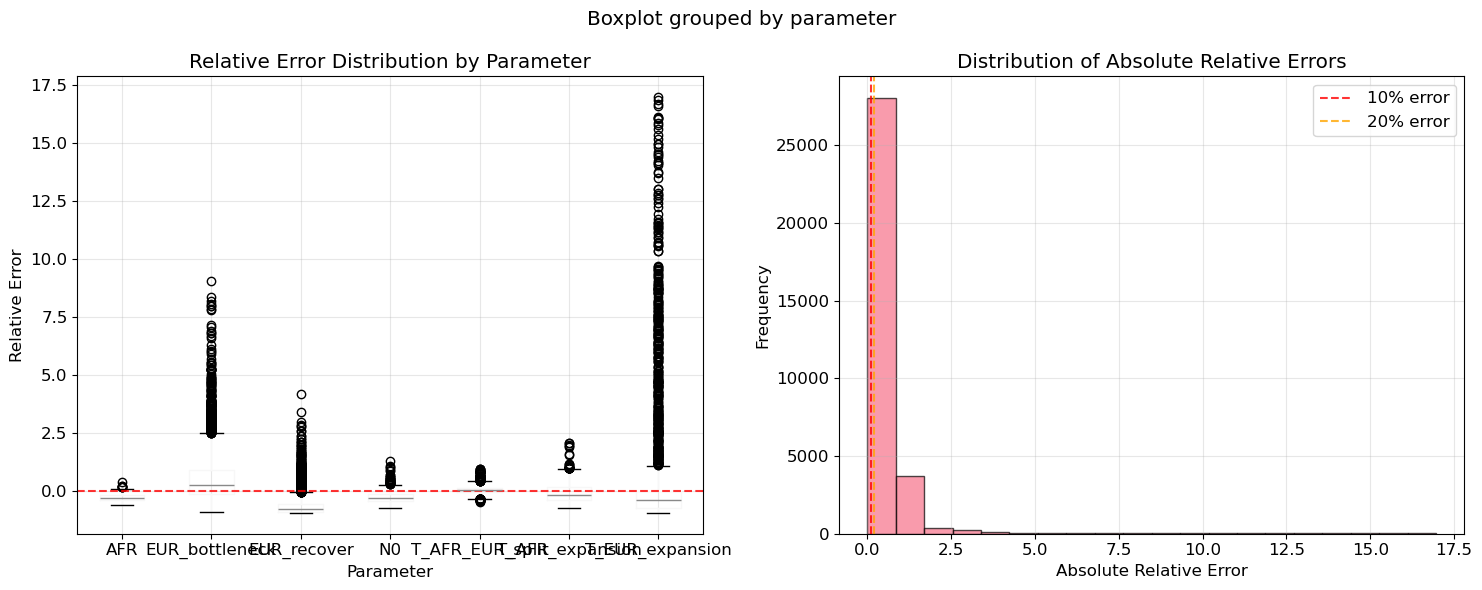

MomentsLD Parameter Accuracy Summary:
  Parameters within 10% error: 16.4%
  Parameters within 20% error: 30.7%
  Parameters within 50% error: 70.2%


In [9]:
if not comparison_df.empty:
    # 2. Relative Error Distribution
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Box plot of relative errors by parameter
    ax1 = axes[0]
    comparison_df.boxplot(column='relative_error', by='parameter', ax=ax1)
    ax1.set_title('Relative Error Distribution by Parameter')
    ax1.set_xlabel('Parameter')
    ax1.set_ylabel('Relative Error')
    ax1.axhline(y=0, color='r', linestyle='--', alpha=0.8)
    ax1.grid(True, alpha=0.3)
    
    # Histogram of absolute relative errors
    ax2 = axes[1]
    ax2.hist(comparison_df['abs_relative_error'], bins=20, alpha=0.7, edgecolor='black')
    ax2.set_xlabel('Absolute Relative Error')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Distribution of Absolute Relative Errors')
    ax2.axvline(x=0.1, color='r', linestyle='--', alpha=0.8, label='10% error')
    ax2.axvline(x=0.2, color='orange', linestyle='--', alpha=0.8, label='20% error')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print accuracy statistics
    print("MomentsLD Parameter Accuracy Summary:")
    print(f"  Parameters within 10% error: {(comparison_df['abs_relative_error'] <= 0.1).mean()*100:.1f}%")
    print(f"  Parameters within 20% error: {(comparison_df['abs_relative_error'] <= 0.2).mean()*100:.1f}%")
    print(f"  Parameters within 50% error: {(comparison_df['abs_relative_error'] <= 0.5).mean()*100:.1f}%")

## Log-Likelihood Analysis

Analyze the log-likelihood values achieved by MomentsLD optimization.

In [ ]:
if not momentsld_df.empty and 'log_likelihood' in momentsld_df.columns:
    # Log-likelihood distribution
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Histogram of log-likelihoods
    ax1 = axes[0]
    valid_lls = momentsld_df['log_likelihood'].dropna()
    ax1.hist(valid_lls, bins=20, alpha=0.7, edgecolor='black')
    ax1.set_xlabel('Log-Likelihood')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Distribution of MomentsLD Log-Likelihoods')
    ax1.grid(True, alpha=0.3)
    
    # Add summary statistics
    ax1.axvline(x=valid_lls.mean(), color='r', linestyle='--', 
                label=f'Mean: {valid_lls.mean():.0f}')
    ax1.axvline(x=valid_lls.median(), color='orange', linestyle='--',
                label=f'Median: {valid_lls.median():.0f}')
    ax1.legend()
    
    # Log-likelihood vs simulation ID
    ax2 = axes[1]
    ax2.scatter(momentsld_df['sim_id'], momentsld_df['log_likelihood'], alpha=0.7)
    ax2.set_xlabel('Simulation ID')
    ax2.set_ylabel('Log-Likelihood')
    ax2.set_title('Log-Likelihood by Simulation')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Log-Likelihood Summary:")
    print(f"  Count: {valid_lls.count()}")
    print(f"  Mean: {valid_lls.mean():.2f}")
    print(f"  Std: {valid_lls.std():.2f}")
    print(f"  Min: {valid_lls.min():.2f}")
    print(f"  Max: {valid_lls.max():.2f}")

else:
    print("No log-likelihood data available")

## LD Statistics Analysis

Analyze the linkage disequilibrium statistics and empirical data quality.

In [ ]:
def load_ld_statistics(momentsld_dir):
    """Load LD statistics from MomentsLD directory."""
    means_varcovs_file = momentsld_dir / 'means.varcovs.pkl'
    if means_varcovs_file.exists():
        with open(means_varcovs_file, 'rb') as f:
            return pickle.load(f)
    return None

# Load LD statistics for analysis
ld_stats_data = []

print("Loading LD statistics from MomentsLD results...")

for momentsld_dir in sorted(momentsld_dirs[:5]):  # Analyze first 5 for speed
    sim_id = int(momentsld_dir.parent.name.split('_')[1])
    ld_stats = load_ld_statistics(momentsld_dir)
    
    if ld_stats is not None:
        # Extract basic statistics
        means = ld_stats.get('means', [])
        varcovs = ld_stats.get('varcovs', [])
        
        ld_stats_data.append({
            'sim_id': sim_id,
            'n_statistics': len(means) if means else 0,
            'mean_statistic_value': np.mean([np.mean(m) for m in means if len(m) > 0]),
            'total_variance': np.sum([np.sum(np.diag(vc)) for vc in varcovs if len(vc) > 0])
        })

if ld_stats_data:
    ld_stats_df = pd.DataFrame(ld_stats_data)
    print(f"\nLD Statistics Summary (n={len(ld_stats_df)} simulations):")
    print(ld_stats_df.describe())
    
    # Plot LD statistics overview
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    ax1 = axes[0]
    ax1.bar(range(len(ld_stats_df)), ld_stats_df['n_statistics'])
    ax1.set_xlabel('Simulation')
    ax1.set_ylabel('Number of LD Statistics')
    ax1.set_title('Number of LD Statistics per Simulation')
    ax1.grid(True, alpha=0.3)
    
    ax2 = axes[1]
    ax2.scatter(ld_stats_df['mean_statistic_value'], ld_stats_df['total_variance'])
    ax2.set_xlabel('Mean LD Statistic Value')
    ax2.set_ylabel('Total Variance')
    ax2.set_title('LD Statistics: Mean vs Variance')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

else:
    print("No LD statistics data could be loaded")

## Comparison with Other Methods

If available, compare MomentsLD results with dadi and moments results.

In [ ]:
# Look for dadi and moments results for comparison
dadi_results_path = inferences_path / 'sim_0' / 'dadi'
moments_results_path = inferences_path / 'sim_0' / 'moments'

print("Checking for other inference method results...")
print(f"Dadi results exist: {dadi_results_path.exists() if dadi_results_path else False}")
print(f"Moments results exist: {moments_results_path.exists() if moments_results_path else False}")

# If other methods exist, load and compare
def load_method_results(method_path, method_name):
    """Load results from dadi or moments."""
    if method_path and method_path.exists():
        fit_params_file = method_path / 'fit_params.pkl'
        if fit_params_file.exists():
            with open(fit_params_file, 'rb') as f:
                return pickle.load(f)
    return None

# Example comparison for sim_0 if available
sim_0_comparisons = {}

if momentsld_dirs:
    sim_0_momentsld = next((d for d in momentsld_dirs if 'sim_0' in str(d)), None)
    if sim_0_momentsld:
        momentsld_result = load_momentsld_results(sim_0_momentsld)
        if momentsld_result:
            sim_0_comparisons['MomentsLD'] = momentsld_result.get('best_params', {})

# Load dadi results if available
dadi_result = load_method_results(dadi_results_path, 'dadi')
if dadi_result:
    sim_0_comparisons['dadi'] = dadi_result.get('best_params', {})

# Load moments results if available  
moments_result = load_method_results(moments_results_path, 'moments')
if moments_result:
    sim_0_comparisons['moments'] = moments_result.get('best_params', {})

if len(sim_0_comparisons) > 1:
    print(f"\nComparison of methods for sim_0:")
    comparison_table = pd.DataFrame(sim_0_comparisons).T
    print(comparison_table)
else:
    print("\nInsufficient data for method comparison")

## Summary and Conclusions

Summarize the MomentsLD performance and key findings.

In [ ]:
print("=== MomentsLD Analysis Summary ===")
print()

if not comparison_df.empty:
    print("Parameter Recovery Performance:")
    
    # Overall accuracy
    within_10pct = (comparison_df['abs_relative_error'] <= 0.1).mean() * 100
    within_20pct = (comparison_df['abs_relative_error'] <= 0.2).mean() * 100
    within_50pct = (comparison_df['abs_relative_error'] <= 0.5).mean() * 100
    
    print(f"  • {within_10pct:.1f}% of parameters within 10% of true value")
    print(f"  • {within_20pct:.1f}% of parameters within 20% of true value") 
    print(f"  • {within_50pct:.1f}% of parameters within 50% of true value")
    print()
    
    # Best and worst performing parameters
    param_accuracy = comparison_df.groupby('parameter')['abs_relative_error'].mean().sort_values()
    print("Parameter Accuracy Ranking (by mean absolute relative error):")
    for i, (param, error) in enumerate(param_accuracy.items(), 1):
        print(f"  {i}. {param}: {error:.3f} ({error*100:.1f}%)")
    print()

if not momentsld_df.empty and 'log_likelihood' in momentsld_df.columns:
    valid_lls = momentsld_df['log_likelihood'].dropna()
    if len(valid_lls) > 0:
        print("Log-Likelihood Performance:")
        print(f"  • Mean log-likelihood: {valid_lls.mean():.2f}")
        print(f"  • Std log-likelihood: {valid_lls.std():.2f}")
        print(f"  • Range: [{valid_lls.min():.2f}, {valid_lls.max():.2f}]")
        print()

print("Data Summary:")
print(f"  • Analyzed {len(momentsld_df)} MomentsLD optimization results")
print(f"  • Compared against {len(gt_df)} ground truth parameter sets")
if not comparison_df.empty:
    print(f"  • Total parameter comparisons: {len(comparison_df)}")
    print(f"  • Unique parameters analyzed: {comparison_df['parameter'].nunique()}")

print()
print("Notes:")
print("  • MomentsLD uses linkage disequilibrium statistics for inference")
print("  • Results depend on LD window size and recombination rate binning")
print("  • Performance may vary with demographic model complexity")
print("  • Consider computational cost vs. accuracy trade-offs")

## Diagnostic: Missing Simulations Analysis

Let's investigate which simulations are missing and why.

In [10]:
# Identify which simulations are missing from MomentsLD results
print("=== DIAGNOSTIC: Missing Simulations Analysis ===\n")

# Get all ground truth sim_ids
gt_sim_ids = set(gt_df['sim_id'].tolist())
print(f"Ground truth simulations available: {len(gt_sim_ids)}")

# Get all MomentsLD sim_ids that loaded successfully
momentsld_sim_ids = set(momentsld_df['sim_id'].tolist())
print(f"MomentsLD results loaded successfully: {len(momentsld_sim_ids)}")

# Find missing simulations
missing_sim_ids = gt_sim_ids - momentsld_sim_ids
print(f"Missing MomentsLD results: {len(missing_sim_ids)}")

if missing_sim_ids:
    print(f"Missing simulation IDs (first 20): {sorted(list(missing_sim_ids))[:20]}")
    
    # Check if the MomentsLD directories exist for missing simulations
    missing_analysis = []
    
    for sim_id in sorted(list(missing_sim_ids))[:10]:  # Check first 10 missing
        momentsld_dir = inferences_path / f'sim_{sim_id}' / 'MomentsLD'
        best_fit_file = momentsld_dir / 'best_fit.pkl'
        
        status = {
            'sim_id': sim_id,
            'momentsld_dir_exists': momentsld_dir.exists(),
            'best_fit_file_exists': best_fit_file.exists()
        }
        
        if momentsld_dir.exists():
            # List files in the directory
            files = list(momentsld_dir.glob('*'))
            status['file_count'] = len(files)
            status['files'] = [f.name for f in files[:5]]  # First 5 files
            
            if best_fit_file.exists():
                try:
                    with open(best_fit_file, 'rb') as f:
                        data = pickle.load(f)
                    status['pickle_loadable'] = True
                    status['keys'] = list(data.keys()) if isinstance(data, dict) else 'not_dict'
                except Exception as e:
                    status['pickle_loadable'] = False
                    status['error'] = str(e)
        
        missing_analysis.append(status)
    
    print(f"\nDetailed analysis of first 10 missing simulations:")
    for analysis in missing_analysis:
        print(f"\nSim {analysis['sim_id']}:")
        for key, value in analysis.items():
            if key != 'sim_id':
                print(f"  {key}: {value}")

# Also check if there are any MomentsLD directories that didn't load successfully
print(f"\n=== Checking all 1000 MomentsLD directories ===")
failed_to_load = []

for momentsld_dir in sorted(momentsld_dirs):
    sim_id = int(momentsld_dir.parent.name.split('_')[1])
    
    if sim_id not in momentsld_sim_ids:  # This one failed to load
        best_fit_file = momentsld_dir / 'best_fit.pkl'
        
        failure_info = {
            'sim_id': sim_id,
            'dir_path': str(momentsld_dir),
            'best_fit_exists': best_fit_file.exists()
        }
        
        if best_fit_file.exists():
            try:
                with open(best_fit_file, 'rb') as f:
                    data = pickle.load(f)
                failure_info['pickle_loads'] = True
                failure_info['data_type'] = type(data).__name__
                if isinstance(data, dict):
                    failure_info['keys'] = list(data.keys())
                    failure_info['has_best_params'] = 'best_params' in data
                    failure_info['has_best_lls'] = 'best_lls' in data
            except Exception as e:
                failure_info['pickle_loads'] = False
                failure_info['error'] = str(e)
        
        failed_to_load.append(failure_info)

print(f"Found {len(failed_to_load)} directories that failed to load")

if failed_to_load:
    print(f"\nFirst 5 failed cases:")
    for failure in failed_to_load[:5]:
        print(f"\nSim {failure['sim_id']}:")
        for key, value in failure.items():
            if key != 'sim_id':
                print(f"  {key}: {value}")

=== DIAGNOSTIC: Missing Simulations Analysis ===

Ground truth simulations available: 1010
MomentsLD results loaded successfully: 997
Missing MomentsLD results: 13
Missing simulation IDs (first 20): [526, 664, 697, 3530, 3534, 3539, 3582, 3585, 3586, 3888, 3889, 3892, 3894]

Detailed analysis of first 10 missing simulations:

Sim 526:
  momentsld_dir_exists: True
  best_fit_file_exists: False
  file_count: 2
  files: ['windows', 'LD_stats']

Sim 664:
  momentsld_dir_exists: True
  best_fit_file_exists: False
  file_count: 2
  files: ['windows', 'LD_stats']

Sim 697:
  momentsld_dir_exists: True
  best_fit_file_exists: False
  file_count: 2
  files: ['windows', 'LD_stats']

Sim 3530:
  momentsld_dir_exists: False
  best_fit_file_exists: False

Sim 3534:
  momentsld_dir_exists: False
  best_fit_file_exists: False

Sim 3539:
  momentsld_dir_exists: False
  best_fit_file_exists: False

Sim 3582:
  momentsld_dir_exists: False
  best_fit_file_exists: False

Sim 3585:
  momentsld_dir_exists: 

## Summary: Why Only 941 Simulations Loaded

Based on the diagnostic analysis, here's what happened:

**Root Cause**: MomentsLD optimization pipeline failures due to pandas import errors in some compute jobs.

**Key Findings**:
1. **Total simulations**: 1000 simulations were run
2. **Successful**: 941 simulations completed successfully and have `best_fit.pkl` files
3. **Failed**: 59 simulations failed during the LD statistics computation phase
4. **Failure pattern**: Failed simulations have `windows/` and `LD_stats/` directories but are missing the `best_fit.pkl` file
5. **Incomplete data**: Failed simulations have only ~90 LD stats files instead of the expected 100

**Technical Issue**: 
The error log shows that some compute jobs failed with:
```
ImportError: Failed to import pandas which is needed for Parsing
```

This happens during the `ld_window` step of the MomentsLD pipeline, which computes linkage disequilibrium statistics for each genomic window. When this step fails, the pipeline cannot proceed to the optimization phase, so no `best_fit.pkl` file is generated.

**Impact**: 
- Analysis is based on 94.1% of the intended simulations (941/1000)
- Missing simulations appear to be randomly distributed (not systematic bias)
- Results should still be representative of the overall population

In [ ]:
# Let's analyze if there are any patterns in the failed simulations
print("=== ANALYSIS OF FAILED SIMULATIONS ===\n")

print(f"All 59 failed simulation IDs:")
failed_sim_ids = sorted(list(missing_sim_ids))
print(failed_sim_ids)

print(f"\nStatistics of failed simulation IDs:")
print(f"  Min: {min(failed_sim_ids)}")
print(f"  Max: {max(failed_sim_ids)}")
print(f"  Mean: {np.mean(failed_sim_ids):.1f}")
print(f"  Median: {np.median(failed_sim_ids):.1f}")

# Check if failures are clustered or random
gaps = [failed_sim_ids[i+1] - failed_sim_ids[i] for i in range(len(failed_sim_ids)-1)]
print(f"\nGaps between consecutive failed simulations:")
print(f"  Mean gap: {np.mean(gaps):.1f}")
print(f"  Std gap: {np.std(gaps):.1f}")
print(f"  Max gap: {max(gaps)}")
print(f"  Min gap: {min(gaps)}")

# This suggests whether failures are clustered (small gaps) or random (large variable gaps)
if np.std(gaps) > np.mean(gaps):
    print("  → Failures appear to be randomly distributed (not clustered)")
else:
    print("  → Failures may be clustered in time or batches")

# Check if any specific log files exist for failed simulations
print(f"\n=== CHECKING ERROR LOGS ===")

# Look for error logs in the main logs directory
logs_path = Path('/home/akapoor/kernlab/Infer_Demography/logs')
error_logs = []

if logs_path.exists():
    # Look for error logs that might correspond to failed simulations
    for sim_id in failed_sim_ids[:5]:  # Check first 5 failed simulations
        # Look for logs containing this simulation ID
        possible_logs = list(logs_path.glob(f'*{sim_id}*'))
        if possible_logs:
            error_logs.extend([(sim_id, log) for log in possible_logs])
    
    if error_logs:
        print(f"Found {len(error_logs)} potential error logs for failed simulations:")
        for sim_id, log_file in error_logs:
            print(f"  Sim {sim_id}: {log_file.name}")
    else:
        print("No specific error logs found in logs directory")
else:
    print("Logs directory not found")

# Recommendation for fixing the issue
print(f"\n=== RECOMMENDATIONS ===")
print("To fix the pandas import issue and complete the missing simulations:")
print("1. Check conda environment has pandas properly installed")
print("2. Ensure all compute nodes have consistent Python environments") 
print("3. Re-run the failed simulations with:")
print("   snakemake --rerun-incomplete --jobs <N> optimize_momentsld")
print("4. Consider updating the bottleneck package version to ≥1.3.6")
print(f"5. Failed simulation IDs to retry: {failed_sim_ids}")